# pycaret을 이용한 가스공급량 예측
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'
* 특성
    * 'month', '시간'으로 기온 예측
    * 기온, 기압, 습도 순서로 예측
    * 각 특성 예측 마다 앞에서 예측한 특성 활용
    * 공급량 예측(6개) : 'month', '시간', '구분', '기온', '기압', '습도'
* 공급량 log적용
* 2개 모델('lightgbm', 'catboost') 예측 평균
* 튜닝X, finalize_model X

In [74]:
# 제출 파일명 : sub22_pycaret10.csv
# 제출 점수 : 0.1070370366(2021-12-01 16:45:05)

## 데이터 가져오기
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'

In [75]:
from pycaret.regression import *

In [76]:
import time
import datetime
import pandas as pd

### 2013-2018년 가스공급량과 기온 자료

In [77]:
total = pd.read_csv('../2013-2018년_가스공급량_기온_습도_기압01.csv')
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


### 2019년 데이터

In [78]:
test2019 = pd.read_csv('../data/test.csv')
test2019.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [79]:
test2019[['연월일', '시간', '구분']] = test2019['일자|시간|구분'].str.split(' ').tolist()
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,A
1,2019-01-01 02 A,2019-01-01,02,A
2,2019-01-01 03 A,2019-01-01,03,A
3,2019-01-01 04 A,2019-01-01,04,A
4,2019-01-01 05 A,2019-01-01,05,A


In [80]:
# 구분 열을 숫자로 바꾸기
d_map = {}
for i, d in enumerate(test2019['구분'].unique()):
    d_map[d] = i
test2019['구분'] = test2019['구분'].map(d_map)
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,0
1,2019-01-01 02 A,2019-01-01,02,0
2,2019-01-01 03 A,2019-01-01,03,0
3,2019-01-01 04 A,2019-01-01,04,0
4,2019-01-01 05 A,2019-01-01,05,0


In [81]:
# 연월일 열은 object형이므로 년, 월, 일로 나눈다.
test2019['연월일'] = pd.to_datetime(test2019['연월일'])
test2019['year'] = test2019['연월일'].dt.year
test2019['month'] = test2019['연월일'].dt.month
test2019['day'] = test2019['연월일'].dt.day
test2019['weekday'] = test2019['연월일'].dt.weekday
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


### 상관계수 확인

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

import platform
from matplotlib import font_manager, rc

path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")

<AxesSubplot:>

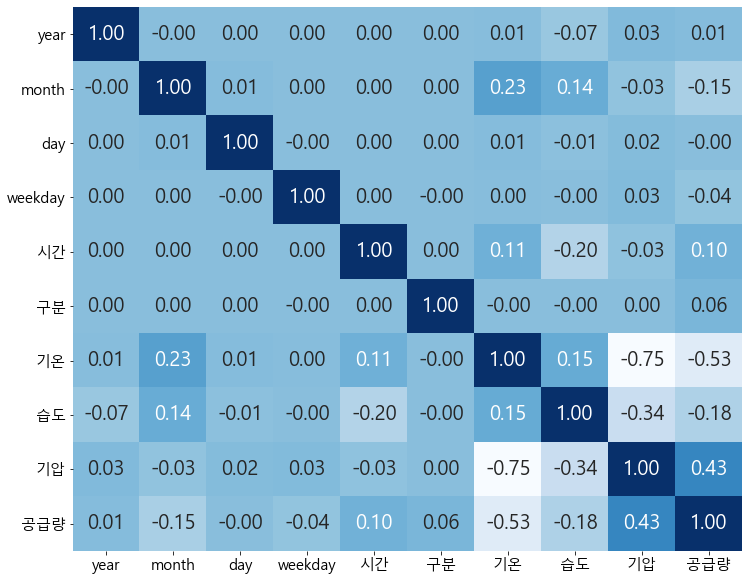

In [83]:
plt.figure(figsize=(12,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.heatmap(total[['year','month', 'day', 'weekday', '시간', '구분', '기온','습도','기압','공급량']].corr(), cmap='Blues', annot=True, fmt='.2f', cbar=False, annot_kws={"size": 20})

(array([ 1631., 12285., 32193., 47222., 53382., 56679., 58002., 46487.,
        38262., 21945.]),
 array([  7. ,  16.3,  25.6,  34.9,  44.2,  53.5,  62.8,  72.1,  81.4,
         90.7, 100. ]),
 <BarContainer object of 10 artists>)

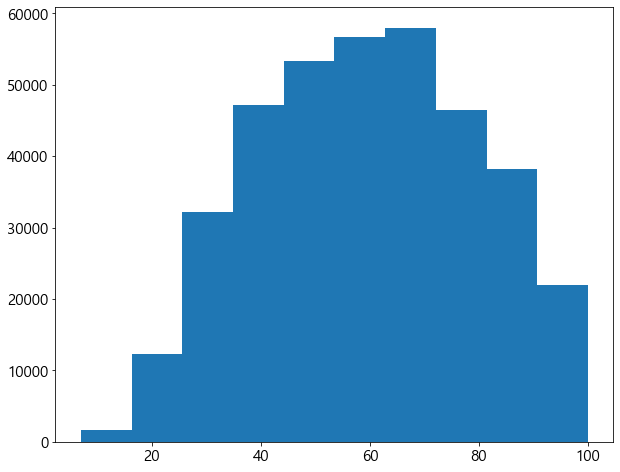

In [84]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='습도', data=total)

(array([  420.,  1414.,  9597., 43568., 77329., 70378., 79037., 60480.,
        23170.,  2695.]),
 array([ 976.5 ,  981.68,  986.86,  992.04,  997.22, 1002.4 , 1007.58,
        1012.76, 1017.94, 1023.12, 1028.3 ]),
 <BarContainer object of 10 artists>)

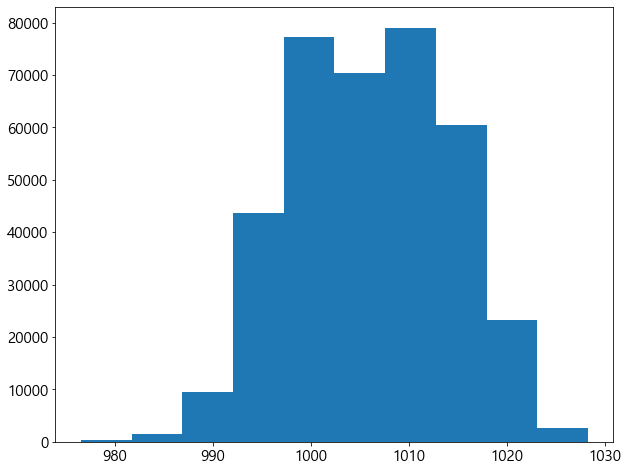

In [85]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='기압', data=total)

(array([ 1708., 12180., 36729., 52906., 48832., 49889., 64701., 73080.,
        26040.,  2023.]),
 array([-18.  , -12.26,  -6.52,  -0.78,   4.96,  10.7 ,  16.44,  22.18,
         27.92,  33.66,  39.4 ]),
 <BarContainer object of 10 artists>)

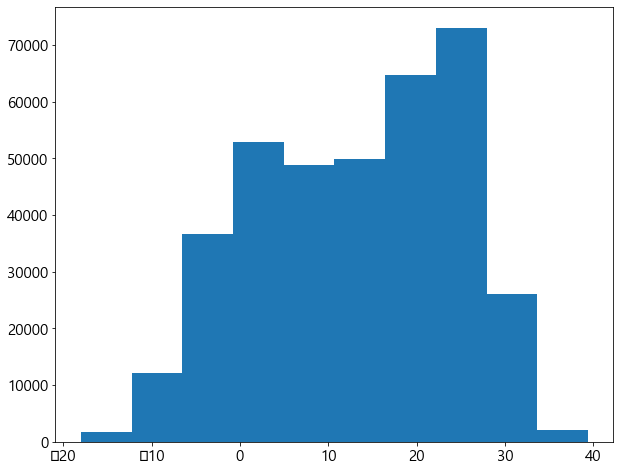

In [86]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='기온', data=total)

(array([2.56069e+05, 7.60110e+04, 2.76280e+04, 7.43600e+03, 8.86000e+02,
        5.30000e+01, 2.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([1.37800000e+00, 1.16060190e+03, 2.31982580e+03, 3.47904970e+03,
        4.63827360e+03, 5.79749750e+03, 6.95672140e+03, 8.11594530e+03,
        9.27516920e+03, 1.04343931e+04, 1.15936170e+04]),
 <BarContainer object of 10 artists>)

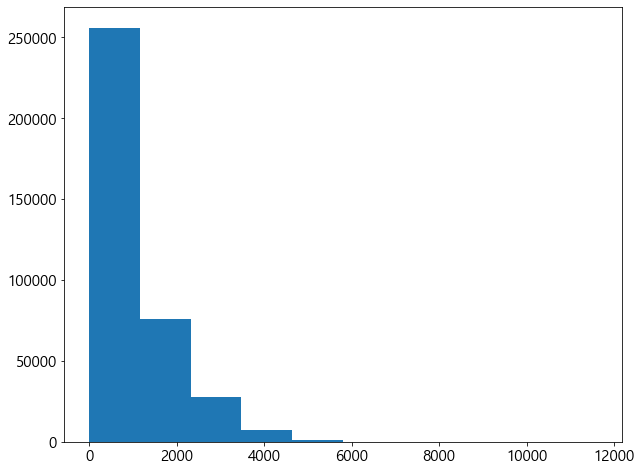

In [87]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='공급량', data=total)

<Figure size 864x576 with 0 Axes>

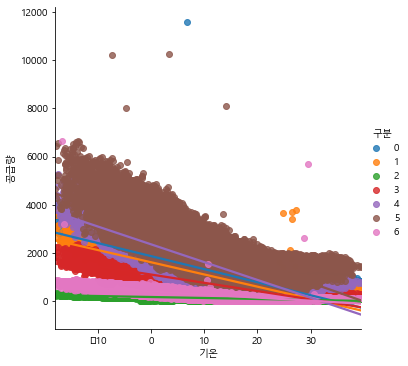

In [88]:
plt.figure(figsize=(12,8))
sns.lmplot(x='기온', y='공급량', hue='구분', data=total)

## 2019년 기온 훈련하기

In [89]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


In [90]:
# 학습 특성 : 'month', '시간'
# 타겟 특성 : '기온'

exp = setup(total, target='기온',
 ignore_features=['공급량', 'year', 'day', 'weekday', '구분', '습도', '기압'],
 silent=True, fold=7, fold_shuffle=True, verbose=False)

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
month,Categorical
시간,Numeric
구분,Categorical
기온,Label


In [18]:
# 모델 비교
# start = time.time()

# compare_models()

# end = time.time()
# sec = end - start
# result = datetime.timedelta(seconds=sec)
# print(str(result).split('.')[0])

In [19]:
# lgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.0226,15.1662,3.8944,0.8803,0.5148,0.7989
1,2.9942,14.9090,3.8612,0.8828,0.5137,0.8119
2,3.0218,15.1660,3.8944,0.8799,0.5145,0.8121
3,3.0170,15.1449,3.8916,0.8805,0.5141,0.8131
4,3.0216,15.1432,3.8914,0.8801,0.5145,0.7813
5,3.0180,15.1437,3.8915,0.8805,0.5148,0.7977
6,3.0108,15.1095,3.8871,0.8806,0.5199,0.8349
Mean,3.0151,15.1118,3.8874,0.8807,0.5152,0.8071
SD,0.0093,0.0846,0.0109,0.0009,0.0020,0.0155


0:00:14


In [20]:
# cat 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.0225,15.1656,3.8943,0.8803,0.5151,0.7992
1,2.9942,14.9085,3.8611,0.8828,0.5136,0.8121
2,3.0219,15.1669,3.8945,0.8799,0.5148,0.8122
3,3.0172,15.1471,3.8919,0.8805,0.5144,0.8131
4,3.0217,15.1431,3.8914,0.8801,0.5145,0.7815
5,3.0181,15.1447,3.8916,0.8805,0.5147,0.7977
6,3.0107,15.1091,3.8870,0.8806,0.5202,0.8350
Mean,3.0152,15.1122,3.8874,0.8807,0.5153,0.8073
SD,0.0094,0.0850,0.0110,0.0009,0.0020,0.0154


0:02:37


### 2019년 기온 예측

In [21]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


In [22]:
# lgbm 기온 예측
start = time.time()

df = test2019[['month', '시간']]
temp2019_pred_lgbm = predict_model(lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [23]:
# cat 기온 예측
start = time.time()

df = test2019[['month', '시간']]
temp2019_pred_cat = predict_model(cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [24]:
temp2019_pred_lgbm.head()

,month,시간,Label
0,1,01,-3.659985
1,1,02,-3.764243
2,1,03,-4.127887
3,1,04,-4.270436
4,1,05,-4.488210


In [25]:
temp2019_pred_cat.head()

,month,시간,Label
0,1,01,-3.666320
1,1,02,-3.748082
2,1,03,-4.125653
3,1,04,-4.271334
4,1,05,-4.507036


In [26]:
# 두 모델 기온 예측 평균
temp2019_pred = (temp2019_pred_lgbm['Label'] + temp2019_pred_cat['Label']) / 2

In [27]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


In [28]:
# 2019년 예측 기온 열 추가
test2019['기온'] = temp2019_pred
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.663152
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.756162
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.126770
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.270885
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.497623


## 2019년 기압 훈련

In [29]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


In [30]:
# 학습 특성 : 'month', '시간', '기온'
# 타겟 특성 : '기압'

exp = setup(total, target='기압', ignore_features=['공급량', 'year', 'weekday', 'day', '습도', '구분'], 
            silent=True, fold=7, fold_shuffle=True, verbose=False)

In [31]:
# # 모델 비교
# start = time.time()

# compare_models()

# end = time.time()
# sec = end - start
# result = datetime.timedelta(seconds=sec)
# print(str(result).split('.')[0])

In [32]:
# lightgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.4932,20.3345,4.5094,0.6875,0.0045,0.0035
1,3.4519,19.7931,4.4489,0.6942,0.0044,0.0034
2,3.4781,20.0606,4.4789,0.6919,0.0045,0.0035
3,3.4604,20.0391,4.4765,0.6946,0.0044,0.0034
4,3.4847,20.1378,4.4875,0.6930,0.0045,0.0035
5,3.4443,19.7641,4.4457,0.6943,0.0044,0.0034
6,3.4562,19.9421,4.4657,0.6923,0.0044,0.0034
Mean,3.4670,20.0102,4.4732,0.6925,0.0044,0.0034
SD,0.0170,0.1841,0.0206,0.0023,0.0000,0.0000


0:00:06


In [33]:
# catboost 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.4306,19.6603,4.4340,0.6979,0.0044,0.0034
1,3.3978,19.1984,4.3816,0.7034,0.0044,0.0034
2,3.4199,19.4100,4.4057,0.7019,0.0044,0.0034
3,3.4080,19.4542,4.4107,0.7035,0.0044,0.0034
4,3.4290,19.4955,4.4154,0.7028,0.0044,0.0034
5,3.3913,19.1159,4.3722,0.7044,0.0043,0.0034
6,3.4037,19.3595,4.3999,0.7013,0.0044,0.0034
Mean,3.4115,19.3848,4.4028,0.7022,0.0044,0.0034
SD,0.0142,0.1696,0.0193,0.0020,0.0000,0.0000


0:02:42


### 2019년 기압 예측

In [34]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.663152
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.756162
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.126770
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.270885
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.497623


In [35]:
# lgbm 모델 기압 예측
start = time.time()

df = test2019[['month', '시간', '기온']]
pressure2019_pred_lgbm = predict_model(lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [36]:
# cat 모델 기압 예측
start = time.time()

df = test2019[['month', '시간', '기온']]
pressure2019_pred_cat = predict_model(cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [37]:
pressure2019_pred_lgbm.head()

,month,시간,기온,Label
0,1,01,-3.663152,1015.392254
1,1,02,-3.756162,1015.213777
2,1,03,-4.126770,1015.154075
3,1,04,-4.270885,1015.070651
4,1,05,-4.497623,1015.496526


In [38]:
pressure2019_pred_cat.head()

,month,시간,기온,Label
0,1,01,-3.663152,1015.336755
1,1,02,-3.756162,1015.351393
2,1,03,-4.126770,1016.000367
3,1,04,-4.270885,1015.656089
4,1,05,-4.497623,1015.671344


In [39]:
# 두 모델 기압 예측 평균
pressure2019_pred = (pressure2019_pred_lgbm['Label'] + pressure2019_pred_cat['Label']) / 2

In [40]:
pressure2019_pred.head()

0    1015.364505
1    1015.282585
2    1015.577221
3    1015.363370
4    1015.583935
Name: Label, dtype: float64

In [41]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.663152
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.756162
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.126770
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.270885
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.497623


In [42]:
# 2019년 예측 기압 열 추가
test2019['기압'] = pressure2019_pred
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.663152,1015.364505
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.756162,1015.282585
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.126770,1015.577221
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.270885,1015.363370
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.497623,1015.583935


## 2019년 습도(Humidity) 훈련

In [43]:
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


In [44]:
# 학습 특성 : 'month', '시간', '기온', '기압'
# 타겟 특성 : '습도'

# 적용 특성 설정
exp = setup(total, target='습도', ignore_features=['공급량', 'year', 'day', 'weekday', '구분'],
 fold=7, fold_shuffle=True, silent=True)

,Description,Value
0,session_id,6690
1,Target,습도
2,Original Data,"(368088, 10)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(257661, 15)"


In [45]:
# # 모델 비교
# start = time.time()

# compare_models()

# end = time.time()
# sec = end - start
# result = datetime.timedelta(seconds=sec)
# print(str(result).split('.')[0])

In [46]:
# lightgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10.4925,178.0412,13.3432,0.5537,0.2572,0.2161
1,10.4610,176.3163,13.2784,0.5528,0.2546,0.2149
2,10.5188,177.7863,13.3337,0.5519,0.2540,0.2141
3,10.5039,177.3680,13.3180,0.5514,0.2546,0.2150
4,10.4880,177.0647,13.3066,0.5523,0.2545,0.2153
5,10.5054,177.8884,13.3375,0.5557,0.2562,0.2165
6,10.5214,177.5570,13.3251,0.5532,0.2557,0.2156
Mean,10.4987,177.4317,13.3203,0.5530,0.2552,0.2154
SD,0.0191,0.5483,0.0206,0.0013,0.0011,0.0007


0:00:06


In [47]:
# catboost 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,9.9427,162.5524,12.7496,0.5926,0.2469,0.2046
1,9.9022,160.9046,12.6848,0.5919,0.2444,0.2034
2,9.9412,162.1472,12.7337,0.5913,0.2440,0.2024
3,9.9530,162.6107,12.7519,0.5887,0.2448,0.2036
4,9.9281,161.6571,12.7144,0.5913,0.2447,0.2039
5,9.9452,161.9572,12.7262,0.5955,0.2457,0.2046
6,9.9446,162.1784,12.7349,0.5919,0.2455,0.2037
Mean,9.9367,162.0011,12.7279,0.5919,0.2451,0.2037
SD,0.0157,0.5413,0.0213,0.0018,0.0009,0.0007


0:02:48


### 2019년 습도 예측

In [48]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.663152,1015.364505
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.756162,1015.282585
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.126770,1015.577221
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.270885,1015.363370
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.497623,1015.583935


In [49]:
# lgbm 모델 습도 예측
start = time.time()

df = test2019[['month', '시간', '기온', '기압']]
humidity2019_pred_lgbm = predict_model(lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [50]:
# cat 모델 습도 예측
start = time.time()

df = test2019[['month', '시간', '기온', '기압']]
humidity2019_pred_cat = predict_model(cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [51]:
humidity2019_pred_lgbm.head()

,month,시간,기온,기압,Label
0,1,01,-3.663152,1015.364505,57.850905
1,1,02,-3.756162,1015.282585,57.374427
2,1,03,-4.126770,1015.577221,59.540978
3,1,04,-4.270885,1015.363370,60.518423
4,1,05,-4.497623,1015.583935,60.779547


In [52]:
humidity2019_pred_cat.head()

,month,시간,기온,기압,Label
0,1,01,-3.663152,1015.364505,56.550056
1,1,02,-3.756162,1015.282585,57.057340
2,1,03,-4.126770,1015.577221,58.770367
3,1,04,-4.270885,1015.363370,59.401318
4,1,05,-4.497623,1015.583935,60.913887


In [53]:
# 두 모델 습도 예측 평균
humidity2019_pred = (humidity2019_pred_lgbm['Label'] + humidity2019_pred_cat['Label']) / 2

In [54]:
humidity2019_pred.head()

0    57.200480
1    57.215883
2    59.155673
3    59.959870
4    60.846717
Name: Label, dtype: float64

In [55]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.663152,1015.364505
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.756162,1015.282585
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.126770,1015.577221
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.270885,1015.363370
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.497623,1015.583935


In [56]:
# 2019년 예측 습도 열 추가
test2019['습도'] = humidity2019_pred
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압,습도
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.663152,1015.364505,57.200480
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.756162,1015.282585,57.215883
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.126770,1015.577221,59.155673
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.270885,1015.363370,59.959870
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.497623,1015.583935,60.846717


## 2019년 가스 공급량 훈련

In [57]:
import numpy as np

In [58]:
total['log_공급량'] = np.log1p(total['공급량'])
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압,log_공급량
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0,7.823297
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0,7.682525
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0,5.425734
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0,7.269280
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0,8.093718


In [59]:
# 학습 특성 : 'month', '시간', '구분', '기온', '기압', '습도'
exp = setup(total, target='log_공급량', ignore_features=['year', 'weekday', '공급량', 'day'],
            silent=True, fold=7, fold_shuffle=True)

,Description,Value
0,session_id,1114
1,Target,log_공급량
2,Original Data,"(368088, 11)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(257661, 23)"


In [60]:
# lgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1426,0.0915,0.3025,0.9352,0.0815,0.0427
1,0.1433,0.0949,0.3081,0.9331,0.0831,0.0435
2,0.1453,0.0978,0.3127,0.9314,0.0841,0.0442
3,0.1436,0.0932,0.3053,0.9353,0.0823,0.0432
4,0.1448,0.0960,0.3098,0.9331,0.0831,0.0436
5,0.1445,0.0974,0.3121,0.9321,0.0843,0.0444
6,0.1443,0.0989,0.3145,0.9317,0.0853,0.0448
Mean,0.1441,0.0957,0.3093,0.9331,0.0834,0.0438
SD,0.0009,0.0024,0.0040,0.0015,0.0012,0.0007


0:00:09


In [61]:
# cat 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1321,0.0835,0.2889,0.9409,0.0782,0.0396
1,0.1331,0.0867,0.2944,0.9389,0.0798,0.0404
2,0.1337,0.0890,0.2984,0.9376,0.0808,0.0408
3,0.1321,0.0847,0.2910,0.9412,0.0791,0.0400
4,0.1336,0.0870,0.2950,0.9394,0.0796,0.0402
5,0.1343,0.0896,0.2994,0.9375,0.0812,0.0413
6,0.1344,0.0911,0.3019,0.9370,0.0823,0.0419
Mean,0.1333,0.0874,0.2956,0.9389,0.0801,0.0406
SD,0.0009,0.0025,0.0043,0.0015,0.0013,0.0008


0:03:46


### 2019년 가스 공급량 예측

In [62]:
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday,기온,기압,습도
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1,-3.663152,1015.364505,57.200480
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1,-3.756162,1015.282585,57.215883
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1,-4.126770,1015.577221,59.155673
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1,-4.270885,1015.363370,59.959870
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1,-4.497623,1015.583935,60.846717


In [63]:
# lgbm log_공급량 예측
start = time.time()

df = test2019[['month', '시간', '구분', '기온', '기압', '습도']]
log_gas2019_pred_lgbm = predict_model(lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [64]:
# cat log_공급량 예측
start = time.time()

df = test2019[['month', '시간', '구분', '기온', '기압', '습도']]
log_gas2019_pred_cat = predict_model(cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

0:00:00


In [65]:
log_gas2019_pred_lgbm.head()

,month,시간,구분,기온,기압,습도,Label
0,1,01,0,-3.663152,1015.364505,57.200480,7.587029
1,1,02,0,-3.756162,1015.282585,57.215883,7.437881
2,1,03,0,-4.126770,1015.577221,59.155673,7.402308
3,1,04,0,-4.270885,1015.363370,59.959870,7.409884
4,1,05,0,-4.497623,1015.583935,60.846717,7.488588


In [66]:
log_gas2019_pred_cat.head()

,month,시간,구분,기온,기압,습도,Label
0,1,01,0,-3.663152,1015.364505,57.200480,7.592283
1,1,02,0,-3.756162,1015.282585,57.215883,7.471011
2,1,03,0,-4.126770,1015.577221,59.155673,7.411718
3,1,04,0,-4.270885,1015.363370,59.959870,7.435386
4,1,05,0,-4.497623,1015.583935,60.846717,7.517473


#### log_공급량을 공급량으로 변환

In [67]:
# lgbm log_공급량 값을 공급량 값으로 변환
gas_pred2019_lgbm = np.expm1(log_gas2019_pred_lgbm['Label'])
gas_pred2019_lgbm.head()

0    1971.444209
1    1698.145375
2    1638.765151
3    1651.234834
4    1786.526153
Name: Label, dtype: float64

In [68]:
# cat log_공급량 값을 공급량 값으로 변환
gas_pred2019_cat = np.expm1(log_gas2019_pred_cat['Label'])
gas_pred2019_cat.head()

0    1981.835376
1    1755.381585
2    1654.266874
3    1693.912040
4    1838.911458
Name: Label, dtype: float64

In [69]:
# 두 모델 공급량 예측 평균
gas2019_pred = (gas_pred2019_lgbm + gas_pred2019_cat) / 2
gas2019_pred.head()

0    1976.639792
1    1726.763480
2    1646.516013
3    1672.573437
4    1812.718805
Name: Label, dtype: float64

## 제출 파일 만들기

In [70]:
sub = pd.read_csv('../data/sample_submission.csv')
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [71]:
sub['공급량'] = gas2019_pred
sub.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,1976.639792
1,2019-01-01 02 A,1726.763480
2,2019-01-01 03 A,1646.516013
3,2019-01-01 04 A,1672.573437
4,2019-01-01 05 A,1812.718805


In [72]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   일자|시간|구분  15120 non-null  object 
 1   공급량       15120 non-null  float64
dtypes: float64(1), object(1)
memory usage: 236.4+ KB


In [73]:
sub.to_csv("sub22_pycaret10.csv", index=False)